In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
infrared_thermography_temperature = fetch_ucirepo(id=925) 

X = infrared_thermography_temperature.data.features 
y = infrared_thermography_temperature.data.targets
df1 = pd.concat([X, y], axis=1)
df = df1.drop('aveOralM', axis=1)

In [3]:
# Partition the data into a training set (80%) and a testing set (20%)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 816, Test size: 204


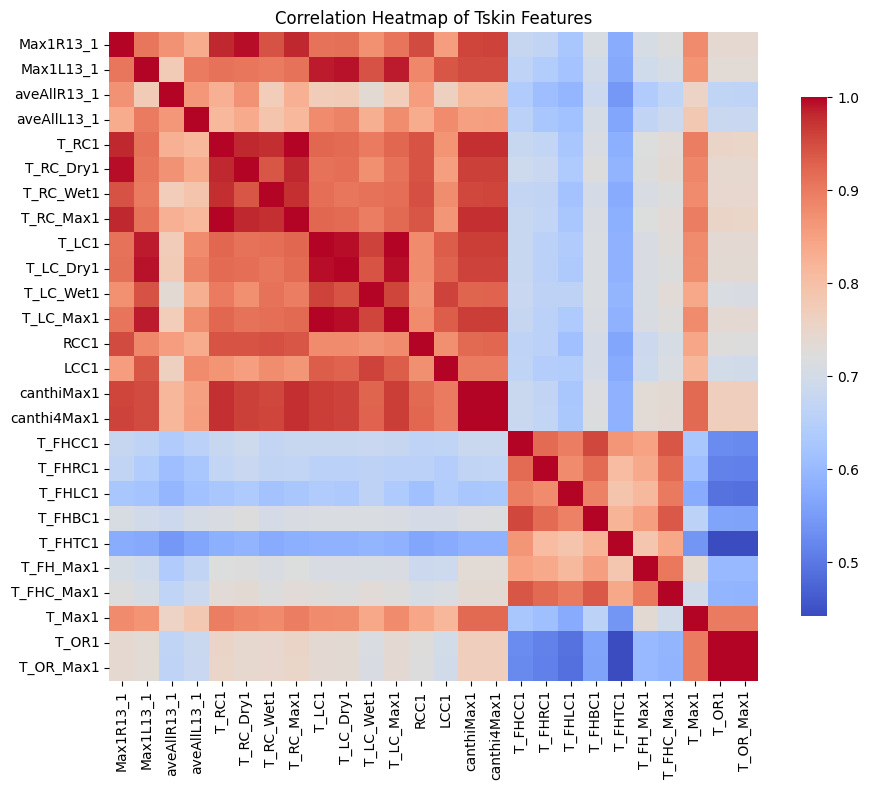

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

target_col = 'aveOralF'

# Define feature groups
env_features = ['T_atm', 'Humidity', 'Distance', 'T_offset1']
continuous_cols = train_df.select_dtypes(include=[float, int]).columns.tolist()
tskin_features = [col for col in continuous_cols if col != target_col and col not in env_features]

# Heatmap of Tskin features
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[tskin_features].corr(), annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Tskin Features")
plt.tight_layout()
plt.show()


In [5]:
# Correlation matrix
corr_matrix = train_df[tskin_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Features to drop if correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Final list
tskin_features_filtered = [col for col in tskin_features if col not in to_drop]

# Print results
print(f"\nTskin features before filtering ({len(tskin_features)}):")
print(tskin_features)

print(f"\nTskin features after filtering ({len(tskin_features_filtered)}):")
print(tskin_features_filtered)



Tskin features before filtering (26):
['Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1']

Tskin features after filtering (12):
['Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1']


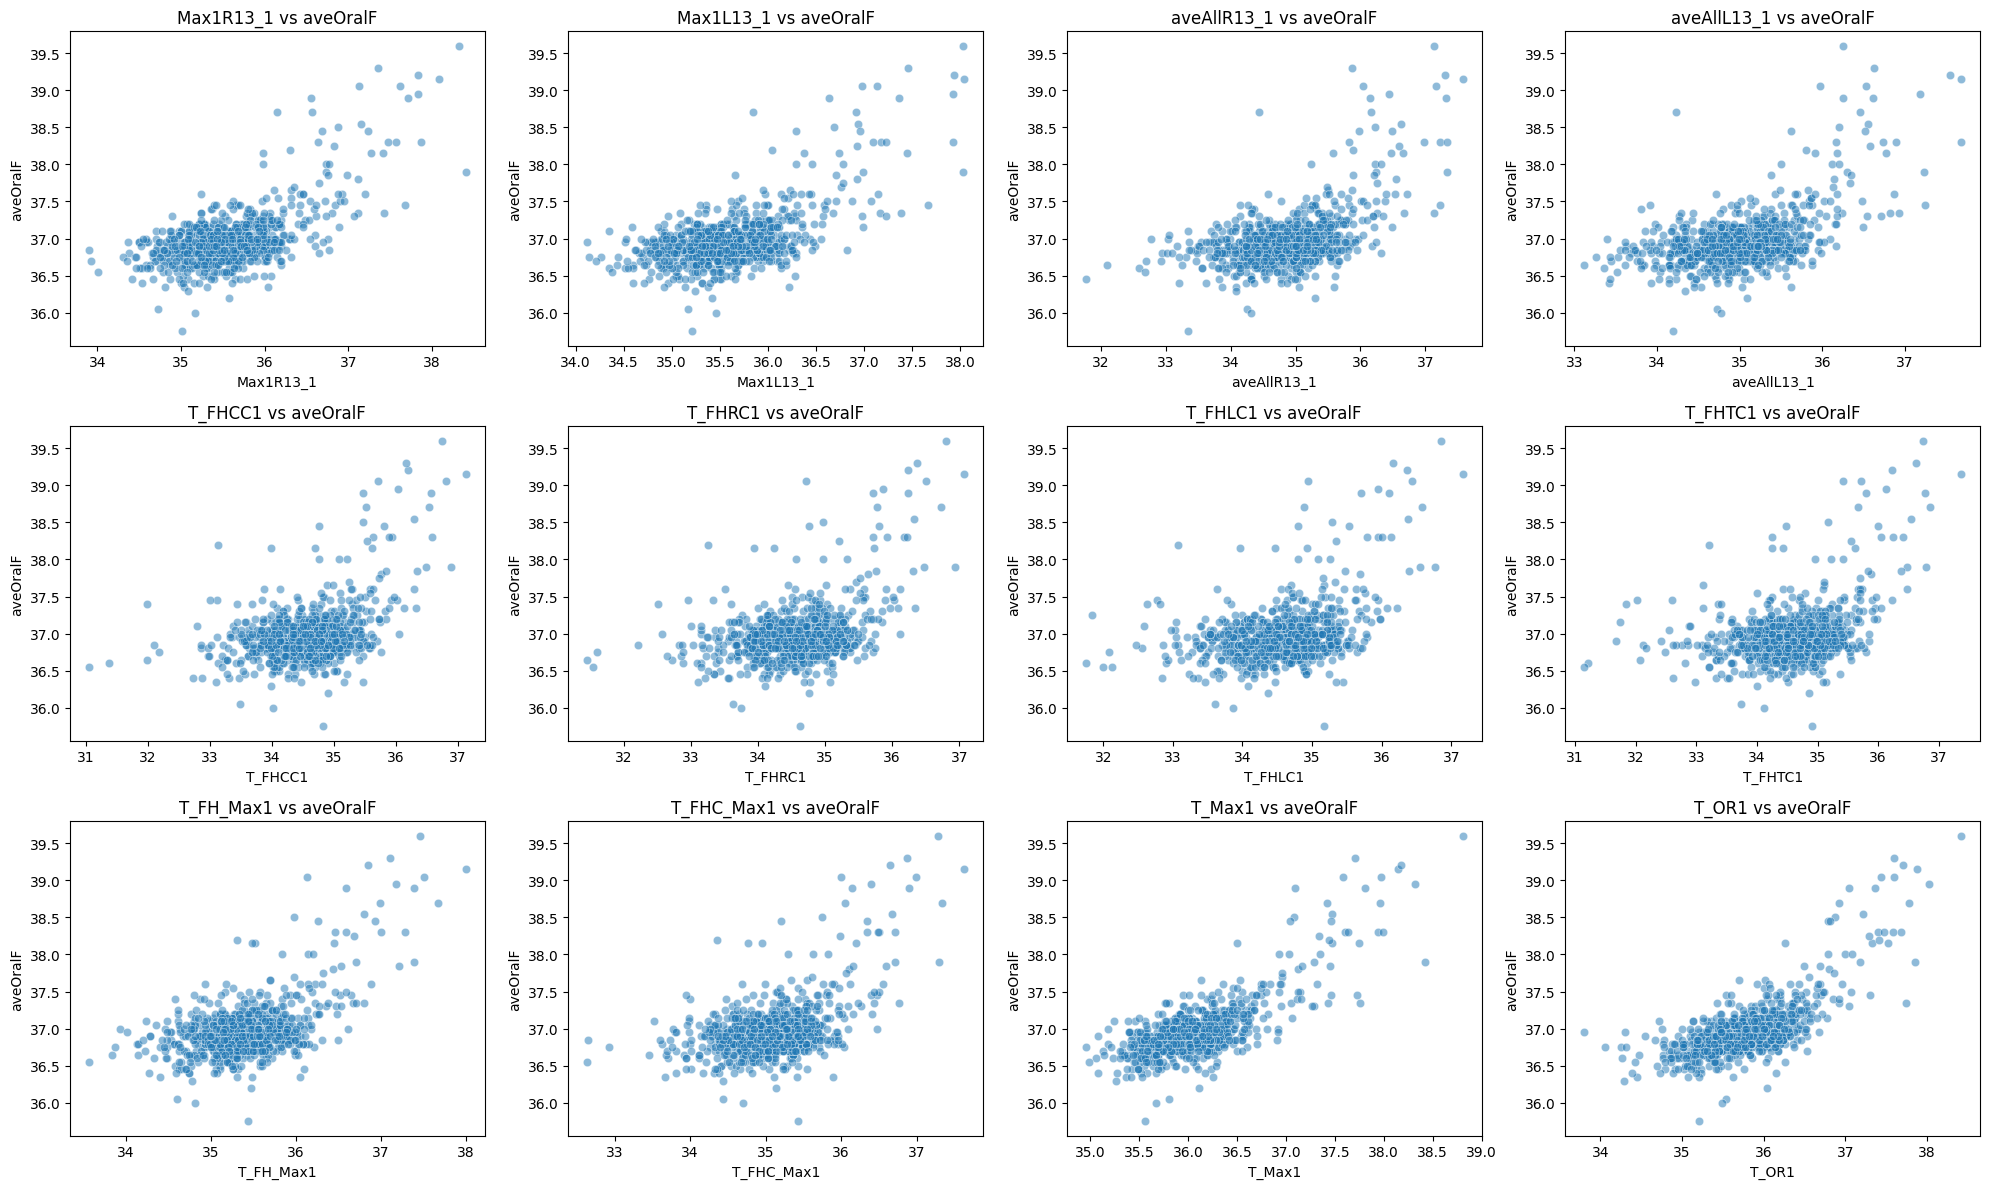

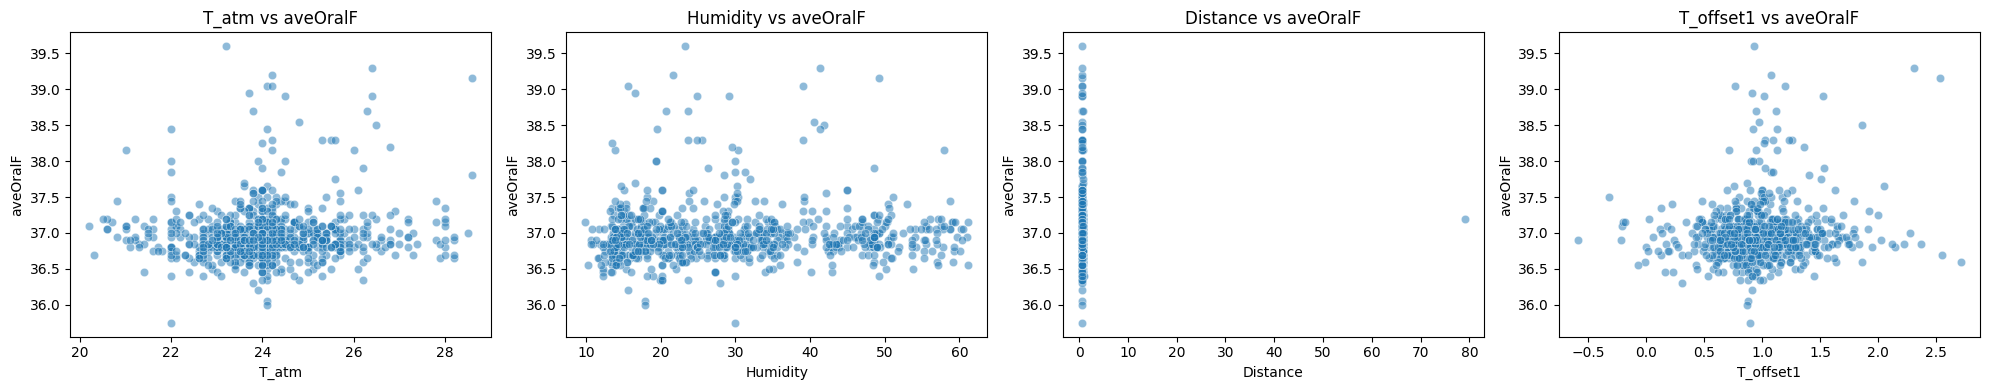

In [6]:
# Scatterplots of filtered Tskin features vs target
n_cols = 4
n_plots = len(tskin_features_filtered)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(tskin_features_filtered):
    sns.scatterplot(data=train_df, x=col, y=target_col, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs {target_col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Scatterplots of environmental features vs target
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()

for i, col in enumerate(env_features):
    sns.scatterplot(data=train_df, x=col, y=target_col, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs {target_col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_col)

plt.tight_layout()
plt.show()



To evaluate the suitability of linear modeling and assess variable behavior, we generated scatterplots between the outcome variable (aveOralF) and each of the selected Tskin and environmental predictors. This visualization step aimed to assess the linearity of relationships, identify potential outliers, and understand the density and spread of data across the range of observed temperatures.

The plots reveal that several Tskin features, including Max1R13_1, Max1L13_1, aveAllR13_1, T_FH_Max1, T_FHC_Max1, T_Max1, and T_OR1, exhibit a reasonably linear positive relationship with aveOralF, suggesting that these variables are likely to contribute predictive signal in a linear regression framework. Some features, particularly those in the forehead region (e.g., T_FHCC1, T_FHRCL, T_FHTC1), show weaker or more diffuse associations with the target, though they still demonstrate visible clustering that may carry information. Among the environmental variables, T_atm, Humidity, and T_offset1 display little to no clear trend with aveOralF, indicating that their influence may be more subtle or nonlinear. Notably, Distance appears highly concentrated around a single value, with limited variability, suggesting minimal predictive contribution and potential for exclusion.

Overall, the scatterplots support the use of linear modeling at this stage, as no strong nonlinear patterns were observed in the predictors or the response. The relationships between selected Tskin features and oral temperature appear sufficiently linear to justify the initial use of linear regression methods. However, while visual inspection does not suggest the immediate need for transformation, we proceed with a formal assessment of skewness and distributional shape in the following steps to determine whether transformation of any predictors may further improve model performance.


Variables to log-transform (|skew| > 1 and positive values only):
Max1R13_1: skew = 1.05
T_Max1: skew = 1.51


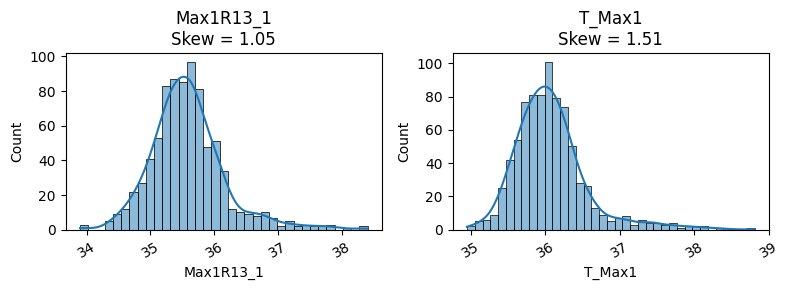

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import skew

# Combine final Tskin and environmental features
reduced_cols = tskin_features_filtered + env_features

log_transform_vars = []
skewness_results = {}

for col in reduced_cols:
    skew_val = skew(train_df[col])
    if abs(skew_val) > 1 and (train_df[col] > 0).all():
        log_transform_vars.append(col)
        skewness_results[col] = skew_val

print("\nVariables to log-transform (|skew| > 1 and positive values only):")
for col in log_transform_vars:
    print(f"{col}: skew = {skewness_results[col]:.2f}")

n_vars = len(log_transform_vars)
n_cols = min(4, n_vars)
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(log_transform_vars):
    skew_val = skewness_results[col]
    sns.histplot(train_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col}\nSkew = {skew_val:.2f}')
    axes[i].tick_params(axis='x', labelrotation=30)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


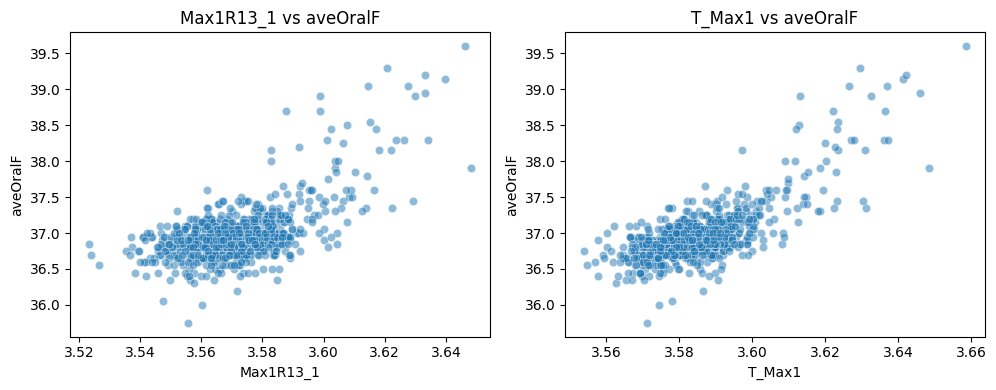

In [8]:
# Make a copy of the training set to avoid modifying the original
train_transformed = train_df.copy()

# Apply log transformation only to the training set
for col in log_transform_vars:
    train_transformed[col] = np.log(train_transformed[col])

n_cols = 3
n_plots = len(log_transform_vars)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(log_transform_vars):
    ax = axes[i]
    sns.scatterplot(data=train_transformed, x=col, y=target_col, ax=ax, alpha=0.5)
    # min_val = min(train_transformed[col].min(), train_transformed[target_col].min())
    # max_val = max(train_transformed[col].max(), train_transformed[target_col].max())
    # ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')
    ax.set_title(f'{col} vs {target_col}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

To evaluate whether transformation of skewed predictors would enhance model performance, we assessed the skewness of all selected features in the training set. Using a conventional threshold of absolute skewness greater than one, and restricting to variables with strictly positive values, two predictors—Max1R13_1 and T_Max1—were identified as moderately right-skewed. Logarithmic transformations were applied to these variables within the training data to reduce asymmetry and improve the linear association with the target variable, aveOralF.

Scatterplots of the log-transformed predictors against aveOralF were then compared to those of the original, untransformed features. The visual patterns revealed minimal change in the distribution of data points or the overall relationship with the target, suggesting that transformation did not meaningfully improve linearity. Based on these results, we chose to retain the original versions of all predictors and proceeded without applying any transformations.